# Construyendo una red neuronal simple

## ¿Qué es una red neuronal?

Vista de forma matemática, una red neuronal es una composición de funciones relativamente sencillas, con una serie de parámetros ajustables. La idea es _entrenar_ dichos parámetros para que el resultado de aplicarle la red neuronal a unos datos determinados sea el que buscamos. Por ejemplo, podemos entrenar redes para distinguir imágenes de perros y de gatos (clasificación), para obtener un hash binario de un documento de texto (aprendizaje de representaciones), para convertir fotografías en pinturas (_transfer learning_)...

En particular, una red tiene la siguiente forma:

$$f^{\theta}=f_n^{\theta} \circ \dots f_2^{\theta} \circ f_1^{\theta}~,$$
donde
$$f_i^{\theta}(x)=s_i(W_i x + b_i),~ W_i\in\mathbb{R}^{n\times m},b_i\in \mathbb R^n$$
y $s_i$ es una función _de activación_, generalmente o bien una función de tipo sigmoidal ($\sigma, \tanh$) o bien cercana a 0 en los negativos y cercana a la identidad en los positivos (ReLU, SELU). En ocasiones $s_i$ es la identidad.

Si $f_i$ tiene la forma descrita arriba, se suele llamar _capa totalmente conectada_ o _densa_. Sin embargo, a veces podemos usar otras funciones en su lugar, que transformen los datos de una forma estática (sin parámetros, _non-trainable_) o con otros parámetros entrenables (_trainable_). Un ejemplo de las primeras sería la transformación que lleva matrices cuadradas $n\times n$ en vectores de $\mathbb R^{n^2}$. Un ejemplo de las segundas serían las [capas convolucionales](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional).

## Definición de un modelo de red neuronal

Antes de nada, vamos a cargar todos los módulos y funciones necesarias:

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

Vamos a explorar un problema muy conocido: la clasificación de dígitos escritos a mano. Como datos de entrada, tendremos imágenes 28$\times$28 que contendrán dígitos del 0 al 9 manuscritos. El objetivo es acertar a qué dígito corresponde la imagen. El siguiente código sirve para cargar los datos:

In [20]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalización a [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

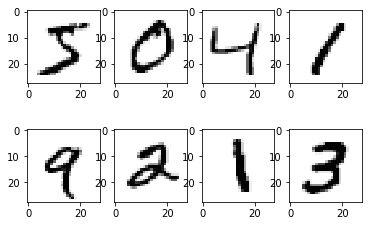

In [23]:
row_size = 4
fig, axs = plt.subplots(ncols=row_size, nrows=2)
for i in range(row_size):
    axs[0, i].imshow(x_train[i], cmap = "Greys")
    axs[1, i].imshow(x_train[row_size + i], cmap = "Greys")

Ahora, construimos nuestro modelo. En este caso y a modo de ejemplo, tomaremos como dato de entrada una imagen de tamaño 28$\times$28, lo llevaremos a un vector de longitud $28\cdot 28 = 784$, y a continuación lo pasaremos por dos capas densas, la primera de dimensión 100 y la segunda de dimensión 10. Esta última capa lleva una función de activación _softmax_, que convierte el vector 10-dimensional en una distribución de probabilidad discreta. De esta forma, la componente de mayor probabilidad se toma como _clase_ del dato que había a la entrada.

In [24]:
model = Sequential([
    Flatten(input_shape = (28, 28)),
    Dense(100, activation = "relu"),
    Dense(10, activation = "softmax")
])

## ¿Cómo se entrena una red neuronal?

Es necesario aplicar alguna estrategia para encontrar los parámetros $\theta$ que mejor se adaptan a nuestro problema. El espacio de búsqueda, sin embargo, suele ser demasiado grande como para hacer una búsqueda exhaustiva o cualquier algoritmo exacto. Por ello, tenemos que recurrir a heurísticas que encuentren soluciones aceptables en un tiempo razonable. Actualmente hay dos vías principales:

1. Descenso del gradiente (estocástico): la idea consiste en [evaluar puntualmente la derivada de la función objetivo](https://en.wikipedia.org/wiki/Backpropagation) (resultante de la composición entre la red neuronal y una _loss_, una métrica de error de la salida obtenida respecto de la deseada), respecto de los parámetros. Cada evaluación nos da la dirección de mayor pendiente, y podemos actualizar los parámetros avanzando "un pasito" en dicha dirección (en sentido de bajada) para minimizar el error. De forma iterativa, llegaremos a algún mínimo local. Este método supone una restricción: la función objetivo debe ser derivable (en la práctica, basta con que sea derivable casi por doquier).

2. Algoritmos evolutivos (neuroevolución): en este caso, se utilizan algoritmos evolutivos como los genéticos para ajustar los parámetros. Se tendrá una población de soluciones y su medida de bondad o _fitness_ equivale a la cercanía entre las salidas que aportan y las deseadas o bien otra puntuación (p.ej. si la red neuronal está jugando a un juego).

Generalmente se suele optar por la vía 1. Sin embargo, la opción 2 es muy utilizada en problemas de aprendizaje por refuerzo, donde la bondad no se mide con el ajuste a una salida prestablecida sino como una puntuación conseguida al realizar alguna acción.

## Entrenando nuestra red

El paso anterior a entrenar el modelo con datos es compilarlo. Esto es necesario para configurar algunos parámetros de entrenamiento y preparar el modelo. Los principales parámetros que hay que establecer son la función objetivo a minimizar (_loss_) y la heurística de optimización (en este caso, RMSProp es una variante de descenso del gradiente estocástico o SGD):

In [26]:
model.compile(loss = "categorical_crossentropy", optimizer = "rmsprop", metrics = ["categorical_accuracy"])

Ya está todo listo para entrenar nuestra red. Para ello usamos `fit`, pasándole los datos de entrenamiento (para los cuales el modelo puede consultar la clase correcta). Es necesario usar `to_categorical` para pasar las clases de $\{0,1,\dots,9\}$ a $\{0,1\}^{10}$:

In [27]:
y_expanded = to_categorical(y_train)
model.fit(x_train, y_expanded, epochs = 20)

Epoch 1/20
60000/60000 [==============================] - 5s 77us/sample - loss: 0.2675 - categorical_accuracy: 0.9238
Epoch 2/20
60000/60000 [==============================] - 4s 69us/sample - loss: 0.1294 - categorical_accuracy: 0.9623
Epoch 3/20
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0951 - categorical_accuracy: 0.9722
Epoch 4/20
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0779 - categorical_accuracy: 0.9782
Epoch 5/20
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0671 - categorical_accuracy: 0.9805
Epoch 6/20
60000/60000 [==============================] - 6s 101us/sample - loss: 0.0580 - categorical_accuracy: 0.9832
Epoch 7/20
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0528 - categorical_accuracy: 0.9857
Epoch 8/20
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0463 - categorical_accuracy: 0.9868
Epoch 9/20
60000/60000 [=======================

Para comprobar cómo de bueno es el modelo conseguido, podemos evaluarlo con nuevos ejemplos que el modelo no ha utilizado para el entrenamiento, los del subconjunto de _test_. La métrica que hemos indicado antes para compilar nos sirve ahora para obtener el acierto global del modelo sobre este conjunto:

In [33]:
loss, accuracy = model.evaluate(x_test, to_categorical(y_test), verbose = 0)

print(f"Acierto del {round(100 * accuracy, 2)}%")

Acierto del 97.34%


Observamos una muestra de los datos de test y la predicción de nuestra red:

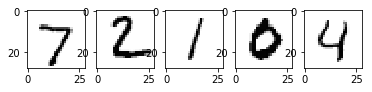

In [49]:
sample_start = 0
sample_size = 5

fig, axs = plt.subplots(ncols=sample_size, nrows=1)
for i in range(sample_size):
    axs[i].imshow(x_test[sample_start + i], cmap = "Greys")

In [50]:
model.predict(x_test[sample_start:sample_size]).argmax(1)

array([7, 2, 1, 0, 4])